<a href="https://colab.research.google.com/github/mhsnur/TESIS-S2-Geomatika-FT-UGM-Muhsin-Nur-Alamsyah/blob/main/RS_RANSAC/RS_RANSAC_KOTA_BARU/KOTA_BARU_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# =========================================
# INSTALL LIBRARY (sekali saja di Colab)
# =========================================
!pip install open3d laspy alphashape shapely descartes --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 156.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.3 MB/s eta 0:00:00


In [ ]:
# =========================================
# RANSAC MULTI-PLANE (PERBAIKAN)
# =========================================

# Install bila perlu (uncomment kalau di Colab)
# !pip install open3d alphashape shapely laspy scikit-learn --quiet

import open3d as o3d
import numpy as np
import laspy
import alphashape
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import random
import os


In [ ]:


# ===========================
# Fungsi bantu
# ===========================
def get_random_color():
    return [random.random(), random.random(), random.random()]

def merge_point_clouds(pcd_list):
    """Gabungkan list Open3D PointCloud menjadi satu PointCloud baru."""
    all_pts = []
    all_colors = []
    for p in pcd_list:
        pts = np.asarray(p.points)
        all_pts.append(pts)
        # jika warna belum ada, buat warna dari p.paint_uniform_color sebelumnya
        try:
            cols = np.asarray(p.colors)
            if cols.shape[0] == 0:
                cols = np.tile(np.array([0.5,0.5,0.5]), (pts.shape[0],1))
        except:
            cols = np.tile(np.array([0.5,0.5,0.5]), (pts.shape[0],1))
        all_colors.append(cols)
    if len(all_pts) == 0:
        return o3d.geometry.PointCloud()
    pts_concat = np.vstack(all_pts)
    cols_concat = np.vstack(all_colors)
    merged = o3d.geometry.PointCloud()
    merged.points = o3d.utility.Vector3dVector(pts_concat)
    merged.colors = o3d.utility.Vector3dVector(cols_concat)
    return merged

def compute_alphashape_area_xy(points_xy, alpha):
    """Return shapely polygon (or None) and area from pts_xy (Nx2)."""
    try:
        shp = alphashape.alphashape(points_xy, alpha=alpha)
        if isinstance(shp, MultiPolygon):
            shp = max(shp.geoms, key=lambda p: p.area)
        return shp, shp.area
    except Exception as e:
        return None, 0.0

# ===========================
# PATH & BACA LAS
# ===========================
las_path = "/content/drive/MyDrive/Segmented_LAS/DATA TESIS/tambah _data/KOTA BARU/kota_baru_BO dan RS/RS/KOTA_BARU_D.las"
if not os.path.exists(las_path):
    raise FileNotFoundError(f"File LAS tidak ditemukan: {las_path}")

las = laspy.read(las_path)
points = np.vstack((las.x, las.y, las.z)).T

# ===========================
# Konversi ke Open3D dan downsample
# ===========================
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd = pcd.voxel_down_sample(voxel_size=0.3)  # ubah 0.2 untuk detail lebih tinggi

# Salin sebagai cloud kerja
cloud = pcd

# ===========================
# Parameter (sesuaikan bila perlu)
# ===========================
distance_threshold = 0.12      # toleransi jarak ke plane (m)
ransac_n = 3
num_iterations = 3000
min_inlier_ratio = 0.032
min_area_threshold = 8.0      # m^2
min_points_per_plane = 100    # titik minimum agar bidang disimpan
alpha_value = 0.5            # alphashape alpha
merge_normal_thresh = 0.8    # ambang cosine similarity (0.95 ~ ~ 18°)

# ===========================
# Prefilter & normal estimation
# ===========================
print("📦 Estimasi normal dan prefilter...")
cloud.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))
# orient normals agar konsisten
cloud.orient_normals_consistent_tangent_plane(50)

# hapus outlier statistik ringan
cloud, ind = cloud.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)

# ===========================
# RANSAC LOOP
# ===========================
plane_list = []
plane_colors = []
normals = []
areas = []

iter_count = 0
while True:
    iter_count += 1
    n_pts = len(cloud.points)
    print(f"🔁 Iter {iter_count} — Titik tersisa: {n_pts}")
    if n_pts < 300:
        print("⚠️ Titik tersisa di bawah threshold, hentikan.")
        break

    plane_model, inliers = cloud.segment_plane(
        distance_threshold=distance_threshold,
        ransac_n=ransac_n,
        num_iterations=num_iterations
    )

    if inliers is None or len(inliers) == 0:
        print("⚠️ Tidak ada inlier, hentikan.")
        break

    inlier_ratio = len(inliers) / n_pts
    if inlier_ratio < min_inlier_ratio:
        print("🚫 Rasio inlier terlalu kecil, hentikan iterasi.")
        break

    plane = cloud.select_by_index(inliers)
    pts = np.asarray(plane.points)

    # filter jumlah titik
    if pts.shape[0] < min_points_per_plane:
        print(f"⚠️ Bidang dibuang (hanya {pts.shape[0]} titik).")
        cloud = cloud.select_by_index(inliers, invert=True)
        continue

    # proyeksi XY dan alphashape area
    pts_xy = pts[:, :2]
    shape, area = compute_alphashape_area_xy(pts_xy, alpha=alpha_value)
    is_valid = (shape is not None) and (area >= min_area_threshold)

    if not is_valid:
        print(f"⚠️ Bidang dilewati (area: {area:.2f} m²).")
    else:
        # simpan plane
        normal = plane_model[:3]
        normal = normal / np.linalg.norm(normal)
        color = get_random_color()
        plane.paint_uniform_color(color)

        plane_list.append(plane)
        plane_colors.append(color)
        normals.append(normal)
        areas.append(area)
        print(f"✅ Bidang disimpan (area {area:.2f} m², titik {pts.shape[0]}).")

    # hapus inlier
    cloud = cloud.select_by_index(inliers, invert=True)

# ===========================
# Merge bidang berdasarkan normal
# ===========================
print("\n🔄 Menggabungkan bidang sejajar berdasarkan normal...")
merged_planes = []
merged_normals = []
merged_colors = []

for i, normal_i in enumerate(normals):
    merged = False
    for j, normal_j in enumerate(merged_normals):
        sim = abs(np.dot(normal_i, normal_j))  # cosine similarity (abs agar arah +/- sama)
        if sim >= merge_normal_thresh:
            # gabungkan pointcloud i ke merged_planes[j]
            merged_planes[j] = merge_point_clouds([merged_planes[j], plane_list[i]])
            merged = True
            break
    if not merged:
        # buat salinan dari plane_list[i] (untuk menghindari referensi yang sama)
        new_pc = o3d.geometry.PointCloud()
        new_pc.points = o3d.utility.Vector3dVector(np.asarray(plane_list[i].points))
        # warna
        try:
            new_pc.colors = o3d.utility.Vector3dVector(np.asarray(plane_list[i].colors))
        except:
            new_pc.paint_uniform_color(plane_colors[i])
        merged_planes.append(new_pc)
        merged_normals.append(normals[i])
        merged_colors.append(plane_colors[i])

print(f"✅ Total bidang akhir setelah merge: {len(merged_planes)}")

# ===========================
# (Opsional) Pasang warna seragam dan saring area kecil lagi
# ===========================
final_planes = []
for idx, mp in enumerate(merged_planes):
    pts = np.asarray(mp.points)
    if pts.shape[0] < min_points_per_plane:
        continue
    # hitung area alphashape dari proyeksi
    shp, area = compute_alphashape_area_xy(pts[:, :2], alpha=alpha_value)
    if shp is None or area < min_area_threshold:
        continue
    # paint uniform dengan warna merged_colors[idx] jika tersedia
    color = merged_colors[idx] if idx < len(merged_colors) else get_random_color()
    mp.paint_uniform_color(color)
    final_planes.append(mp)

print(f"✅ Final planes after filtering: {len(final_planes)}")

# ===========================
# Simpan & visualisasikan
# ===========================
if len(final_planes) > 0:
    # gabungkan semua plane untuk preview
    preview = merge_point_clouds(final_planes)
    o3d.visualization.draw_geometries([preview], window_name="RANSAC Multi-Plane Result")
    # simpan tiap plane ke file PLY
    out_dir = "/content/plane_outputs"
    os.makedirs(out_dir, exist_ok=True)
    for i, p in enumerate(final_planes):
        out_path = os.path.join(out_dir, f"plane_{i+1}.ply")
        o3d.io.write_point_cloud(out_path, p)
    print(f"✅ Disimpan {len(final_planes)} plane ke folder: {out_dir}")
else:
    print("⚠️ Tidak ada plane akhir untuk ditampilkan atau disimpan.")


📦 Estimasi normal dan prefilter...
🔁 Iter 1 — Titik tersisa: 75254
✅ Bidang disimpan (area 181.41 m², titik 4952).
🔁 Iter 2 — Titik tersisa: 70302
✅ Bidang disimpan (area 215.16 m², titik 4085).
🔁 Iter 3 — Titik tersisa: 66217


✅ Bidang disimpan (area 228.49 m², titik 4096).
🔁 Iter 4 — Titik tersisa: 62121


✅ Bidang disimpan (area 146.01 m², titik 3438).
🔁 Iter 5 — Titik tersisa: 58683
✅ Bidang disimpan (area 228.90 m², titik 3727).
🔁 Iter 6 — Titik tersisa: 54956


✅ Bidang disimpan (area 226.37 m², titik 3389).
🔁 Iter 7 — Titik tersisa: 51567
✅ Bidang disimpan (area 116.72 m², titik 3019).
🔁 Iter 8 — Titik tersisa: 48548


✅ Bidang disimpan (area 142.26 m², titik 3025).
🔁 Iter 9 — Titik tersisa: 45523
✅ Bidang disimpan (area 165.27 m², titik 2570).
🔁 Iter 10 — Titik tersisa: 42953
✅ Bidang disimpan (area 295.78 m², titik 2510).
🔁 Iter 11 — Titik tersisa: 40443
✅ Bidang disimpan (area 122.65 m², titik 2269).
🔁 Iter 12 — Titik tersisa: 38174
✅ Bidang disimpan (area 122.57 m², titik 1956).
🔁 Iter 13 — Titik tersisa: 36218
✅ Bidang disimpan (area 133.66 m², titik 1902).
🔁 Iter 14 — Titik tersisa: 34316
✅ Bidang disimpan (area 109.99 m², titik 1904).
🔁 Iter 15 — Titik tersisa: 32412
✅ Bidang disimpan (area 65.90 m², titik 1783).
🔁 Iter 16 — Titik tersisa: 30629


✅ Bidang disimpan (area 122.95 m², titik 1646).
🔁 Iter 17 — Titik tersisa: 28983
✅ Bidang disimpan (area 120.76 m², titik 1834).
🔁 Iter 18 — Titik tersisa: 27149
✅ Bidang disimpan (area 68.83 m², titik 1619).
🔁 Iter 19 — Titik tersisa: 25530
✅ Bidang disimpan (area 139.48 m², titik 1525).
🔁 Iter 20 — Titik tersisa: 24005
✅ Bidang disimpan (area 95.78 m², titik 1476).
🔁 Iter 21 — Titik tersisa: 22529


✅ Bidang disimpan (area 95.39 m², titik 1274).
🔁 Iter 22 — Titik tersisa: 21255
✅ Bidang disimpan (area 118.63 m², titik 1580).
🔁 Iter 23 — Titik tersisa: 19675
✅ Bidang disimpan (area 52.02 m², titik 1119).
🔁 Iter 24 — Titik tersisa: 18556
✅ Bidang disimpan (area 42.57 m², titik 1034).
🔁 Iter 25 — Titik tersisa: 17522
✅ Bidang disimpan (area 65.45 m², titik 1075).
🔁 Iter 26 — Titik tersisa: 16447
✅ Bidang disimpan (area 69.02 m², titik 902).
🔁 Iter 27 — Titik tersisa: 15545
✅ Bidang disimpan (area 104.58 m², titik 919).
🔁 Iter 28 — Titik tersisa: 14626
✅ Bidang disimpan (area 42.38 m², titik 937).
🔁 Iter 29 — Titik tersisa: 13689


✅ Bidang disimpan (area 129.91 m², titik 829).
🔁 Iter 30 — Titik tersisa: 12860
✅ Bidang disimpan (area 15.86 m², titik 701).
🔁 Iter 31 — Titik tersisa: 12159
✅ Bidang disimpan (area 185.18 m², titik 726).
🔁 Iter 32 — Titik tersisa: 11433
✅ Bidang disimpan (area 44.90 m², titik 679).
🔁 Iter 33 — Titik tersisa: 10754
✅ Bidang disimpan (area 19.67 m², titik 670).
🔁 Iter 34 — Titik tersisa: 10084
✅ Bidang disimpan (area 23.67 m², titik 629).
🔁 Iter 35 — Titik tersisa: 9455
✅ Bidang disimpan (area 184.28 m², titik 590).
🔁 Iter 36 — Titik tersisa: 8865


✅ Bidang disimpan (area 31.70 m², titik 567).
🔁 Iter 37 — Titik tersisa: 8298
✅ Bidang disimpan (area 44.59 m², titik 508).
🔁 Iter 38 — Titik tersisa: 7790
✅ Bidang disimpan (area 23.26 m², titik 495).
🔁 Iter 39 — Titik tersisa: 7295
✅ Bidang disimpan (area 13.73 m², titik 486).
🔁 Iter 40 — Titik tersisa: 6809
✅ Bidang disimpan (area 32.57 m², titik 422).
🔁 Iter 41 — Titik tersisa: 6387
✅ Bidang disimpan (area 12.19 m², titik 400).
🔁 Iter 42 — Titik tersisa: 5987
✅ Bidang disimpan (area 12.71 m², titik 345).
🔁 Iter 43 — Titik tersisa: 5642
✅ Bidang disimpan (area 17.83 m², titik 347).
🔁 Iter 44 — Titik tersisa: 5295
⚠️ Bidang dilewati (area: 5.70 m²).
🔁 Iter 45 — Titik tersisa: 4962
✅ Bidang disimpan (area 107.31 m², titik 295).
🔁 Iter 46 — Titik tersisa: 4667
✅ Bidang disimpan (area 29.91 m², titik 279).
🔁 Iter 47 — Titik tersisa: 4388
✅ Bidang disimpan (area 9.53 m², titik 250).
🔁 Iter 48 — Titik tersisa: 4138
✅ Bidang disimpan (area 9.69 m², titik 233).
🔁 Iter 49 — Titik tersisa: 39

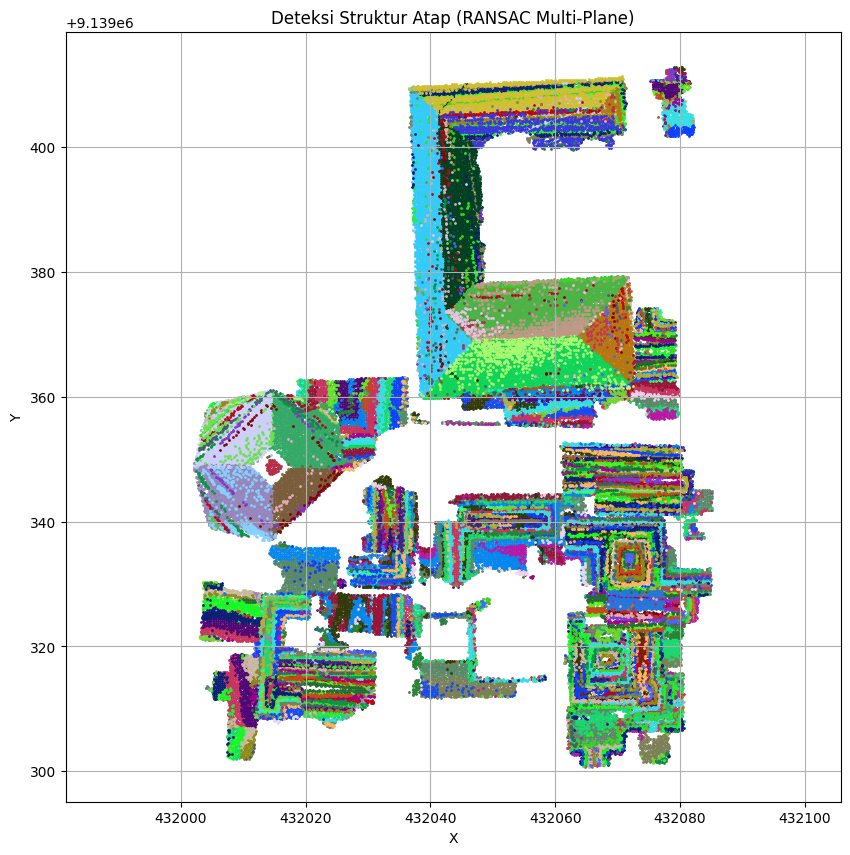

In [ ]:
plt.figure(figsize=(10, 10))

for plane, color in zip(plane_list, plane_colors):
    pts = np.asarray(plane.points)
    plt.scatter(pts[:, 0], pts[:, 1], s=1, color=color)

plt.xlabel("X")
plt.ylabel("Y")
plt.title("Deteksi Struktur Atap (RANSAC Multi-Plane)")
plt.axis("equal")
plt.grid(True)
plt.show()


In [ ]:
outlines = []
outline_colors = []

for idx, plane in enumerate(plane_list):
    pts = np.asarray(plane.points)
    pts_xy = pts[:, :2]  # Proyeksi ke XY

    try:
        alpha = 0.44
        shape = alphashape.alphashape(pts_xy, alpha)

        if isinstance(shape, MultiPolygon):
            largest = max(shape.geoms, key=lambda p: p.area)
            outlines.append(largest)
        elif isinstance(shape, Polygon):
            outlines.append(shape)
        else:
            print(f"⚠️ Plane {idx} menghasilkan bukan polygon.")
            continue

        outline_colors.append(plane_colors[idx])

    except Exception as e:
        print(f"❌ Gagal alphashape untuk plane {idx}: {e}, fallback ke convex hull.")
        try:
            from shapely.geometry import MultiPoint
            hull = MultiPoint(pts_xy).convex_hull
            outlines.append(hull)
            outline_colors.append(plane_colors[idx])
        except Exception as ee:
            print(f"‼️ Gagal convex hull juga untuk plane {idx}: {ee}")
            continue


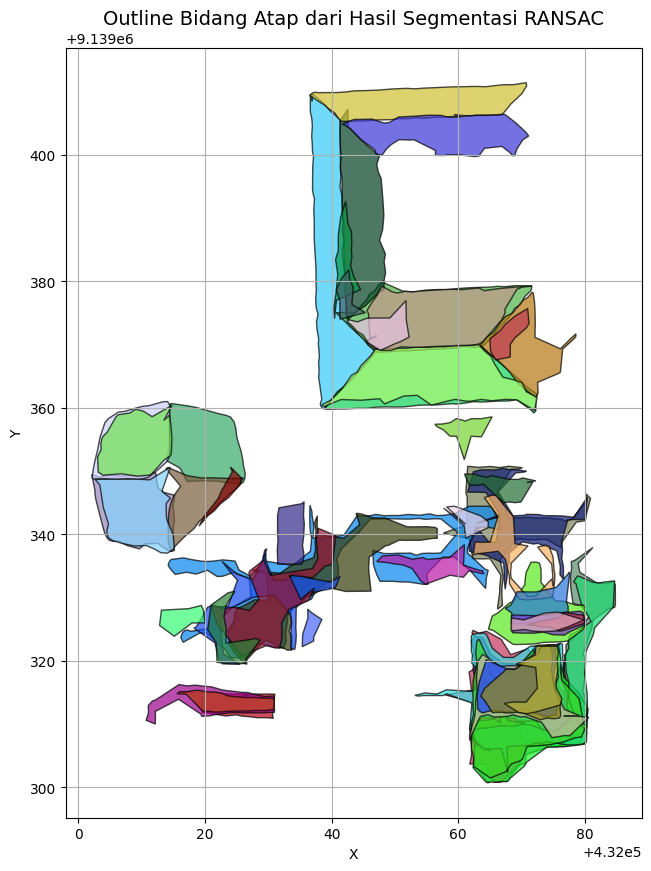

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

for poly, color in zip(outlines, outline_colors):
    x, y = poly.exterior.xy
    ax.fill(x, y, color=color, alpha=0.7, edgecolor='black')

ax.set_aspect('equal')
ax.set_title("Outline Bidang Atap dari Hasil Segmentasi RANSAC", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()


In [ ]:
import geopandas as gpd

# Buat GeoDataFrame
gdf = gpd.GeoDataFrame(
    {"id": list(range(1, len(outlines)+1))},
    geometry=outlines,
    crs="EPSG:32749"   # ganti sesuai CRS kamu
)

# Simpan ke GeoJSON
output_path = "/content/drive/MyDrive/Segmented_LAS/DATA TESIS/tambah _data/KOTA BARU/kota_baru_BO dan RS/RS/KOTA_BARU_D.geojson"
gdf.to_file(output_path, driver="GeoJSON")

print(f"✅ GeoJSON berhasil disimpan ke: {output_path}")


✅ GeoJSON berhasil disimpan ke: /content/drive/MyDrive/Segmented_LAS/DATA TESIS/tambah _data/KOTA BARU/kota_baru_BO dan RS/RS/KOTA_BARU_D.geojson


In [ ]:
from shapely.geometry import LineString, MultiPoint

outline_lines = []  # simpan semua garis outline

for idx, plane in enumerate(plane_list):
    pts = np.asarray(plane.points)
    pts_xy = pts[:, :2]  # hanya X dan Y

    try:
        alpha = 0.22
        shape = alphashape.alphashape(pts_xy, alpha)

        if isinstance(shape, MultiPolygon):
            largest = max(shape.geoms, key=lambda p: p.area)
            exterior = largest.exterior
        elif isinstance(shape, Polygon):
            exterior = shape.exterior
        else:
            print(f"⚠️ Plane {idx} tidak menghasilkan polygon.")
            continue

        # Simpan garis (LineString)
        line = LineString(exterior.coords)
        outline_lines.append((line, plane_colors[idx]))

    except Exception as e:
        print(f"❌ Alphashape gagal untuk plane {idx}, fallback ke convex hull.")
        try:
            hull = MultiPoint(pts_xy).convex_hull
            line = LineString(hull.exterior.coords)
            outline_lines.append((line, plane_colors[idx]))
        except Exception as ee:
            print(f"‼️ Gagal juga convex hull: {ee}")
            continue


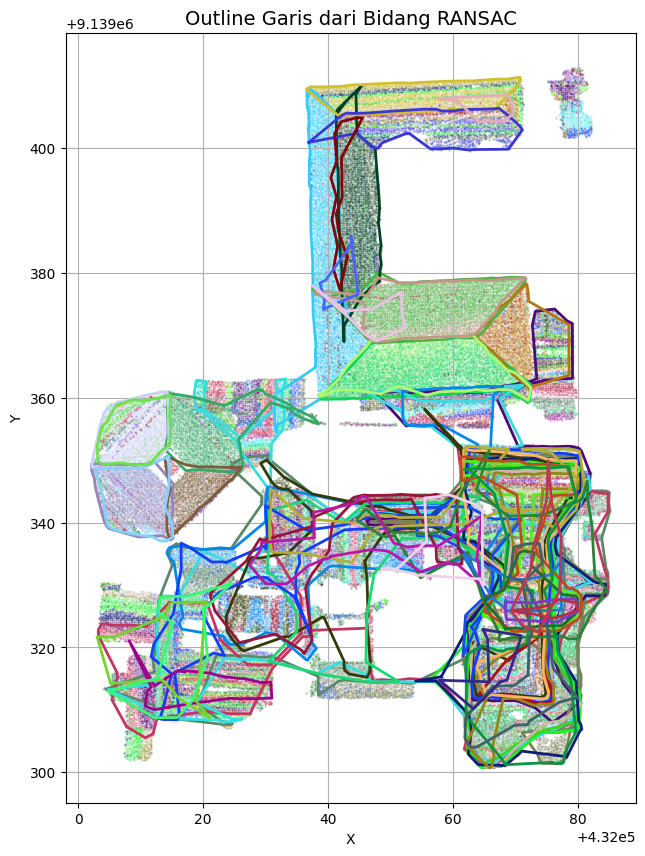

In [ ]:
# =============================================
# TAMPILKAN OUTLINE LINE DENGAN MATPLOTLIB
# =============================================
fig, ax = plt.subplots(figsize=(10, 10))

# Plot garis dari alphashape
for line, color in outline_lines:
    x, y = line.xy
    ax.plot(x, y, color=color, linewidth=2)

# Tambahkan titik point cloud untuk konteks
for plane, color in zip(plane_list, plane_colors):
    pts = np.asarray(plane.points)
    ax.scatter(pts[:, 0], pts[:, 1], s=0.5, color=color, alpha=0.3)

ax.set_aspect('equal')
ax.set_title("Outline Garis dari Bidang RANSAC", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()


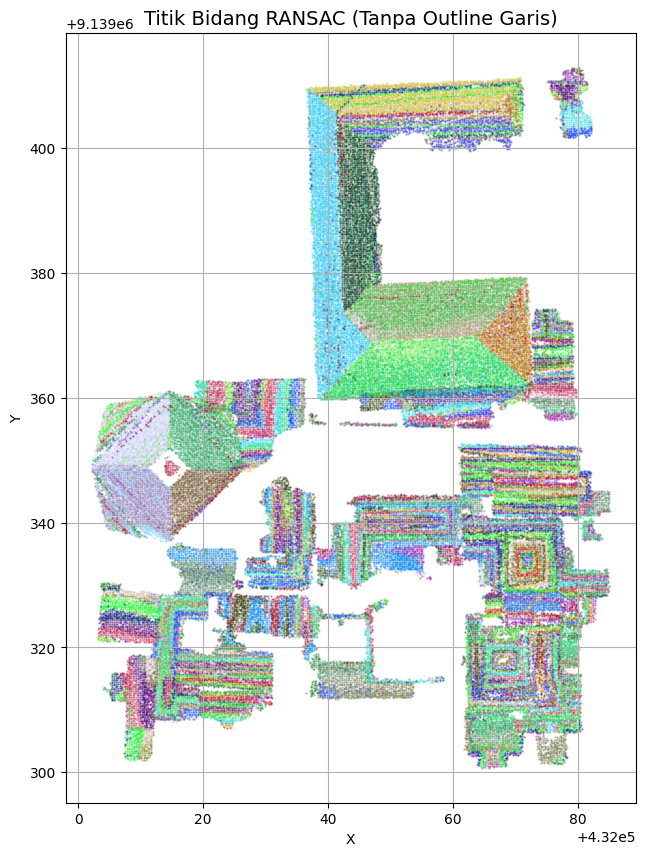

In [ ]:
# =============================================
# TAMPILKAN TITIK SAJA DENGAN MATPLOTLIB
# (Tanpa garis/outline LineString)
# =============================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# Hanya plot titik point cloud hasil RANSAC
for plane, color in zip(plane_list, plane_colors):
    pts = np.asarray(plane.points)
    ax.scatter(pts[:, 0], pts[:, 1], s=0.5, color=color, alpha=0.4)

ax.set_aspect('equal')
ax.set_title("Titik Bidang RANSAC (Tanpa Outline Garis)", fontsize=14)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)
plt.show()
